# Practice-1: elastic body collision

> By Yongjin Choi, Georgia Institute of Technology [Website](https://sites.google.com/view/geo-yjchoi)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yjchoi1/learn-mpm-2d/blob/main/book/mpm2d-elastic-ball.ipynb)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.collections import PolyCollection
from matplotlib.collections import LineCollection


## Problem

This example considers two elastic circular body colliding with specified initial velocity. Two body has the same material property.

![practice-1](https://raw.githubusercontent.com/yjchoi1/learn-mpm-2d/main/book/figs/sim_config.png)


## Helper functions

In [2]:
def elasticity_matrix(youngs_modulus: float, poissons_ratio: float, stress_state: str) -> np.ndarray:
    """Compute the elasticity (stiffness) matrix for an isotropic elastic material.
    
    Args:
        youngs_modulus: Young's modulus of the material.
        poissons_ratio: Poisson's ratio of the material.
        stress_state: Type of stress state. Must be one of "PLANE_STRESS", 
                      "PLANE_STRAIN", or "3D".
    
    Returns:
        Elasticity matrix as a numpy array.
        
    Raises:
        ValueError: If an invalid stress_state is provided.
    """
    if stress_state == 'PLANE_STRESS':
        C = youngs_modulus / (1 - poissons_ratio**2) * np.array([
            [1, poissons_ratio, 0],
            [poissons_ratio, 1, 0],
            [0, 0, (1 - poissons_ratio) / 2]
        ])
    elif stress_state == 'PLANE_STRAIN':
        C = youngs_modulus / ((1 + poissons_ratio) * (1 - 2 * poissons_ratio)) * np.array([
            [1 - poissons_ratio, poissons_ratio, 0],
            [poissons_ratio, 1 - poissons_ratio, 0],
            [0, 0, 0.5 - poissons_ratio]
        ])
    else:  # 3D stress state
        C = np.zeros((6, 6))
        C[:3, :3] = youngs_modulus / ((1 + poissons_ratio) * (1 - 2 * poissons_ratio)) * np.array([
            [1 - poissons_ratio, poissons_ratio, poissons_ratio],
            [poissons_ratio, 1 - poissons_ratio, poissons_ratio],
            [poissons_ratio, poissons_ratio, 1 - poissons_ratio]
        ])
        C[3:, 3:] = youngs_modulus / (2 * (1 + poissons_ratio)) * np.eye(3)
    return C


def generate_circle_particles(center: list, radius: float, spacing: float) -> np.ndarray:
    """Generate a set of particle coordinates within a circle.
    
    Args:
        center: [x, y] coordinates of the circle center.
        radius: Radius of the circle.
        spacing: Grid spacing between particles.
    
    Returns:
        Array of particle positions, each row as [x, y].
    """
    center_array = np.array(center)
    # Determine grid origin so that the grid is consistent regardless of the circle center.
    grid_origin = (center_array // spacing) * spacing

    # Define grid limits based on the circle radius.
    xmin, ymin = grid_origin - radius
    xmax, ymax = grid_origin + radius

    # Generate grid points.
    x_coords = np.arange(xmin, xmax + spacing, spacing)
    y_coords = np.arange(ymin, ymax + spacing, spacing)
    Xp, Yp = np.meshgrid(x_coords, y_coords)
    Xp = Xp.flatten()
    Yp = Yp.flatten()

    # Keep only points that lie inside the circle.
    inside = (Xp - center_array[0])**2 + (Yp - center_array[1])**2 <= radius**2
    return np.vstack([Xp[inside], Yp[inside]]).T


def particle_element_mapping(particle_positions: np.ndarray, cell_width: float, cell_height: float,
                             n_ele_x: int, n_elements: int):
    """Map each particle to an element based on its position.
    
    Args:
        particle_positions: Particle positions as an array of shape (n_particles, 2).
        cell_width: Element (cell) width in the x-direction.
        cell_height: Element (cell) height in the y-direction.
        n_ele_x: Number of elements in the x-direction.
        n_elements: Total number of elements.
    
    Returns:
        ele_ids: Array of element ids for each particle.
        particle_ids_in_elements: List of particle indices for each element.
    """
    x_indices = np.floor(particle_positions[:, 0] / cell_width).astype(int)
    y_indices = np.floor(particle_positions[:, 1] / cell_height).astype(int)
    ele_ids = x_indices + n_ele_x * y_indices

    particle_ids_in_elements = [[] for _ in range(n_elements)]
    for p, e in enumerate(ele_ids):
        particle_ids_in_elements[e].append(p)

    return ele_ids, particle_ids_in_elements


def lagrange_basis(element_type: str, local_coord: np.ndarray):
    """Compute the shape functions and their derivatives for a finite element.
    
    Args:
        element_type: Type of element. Currently only "Q4" is supported.
        local_coord: Array of local coordinates [xi, eta].
    
    Returns:
        N: Shape function values.
        dN_dxi: Derivatives of the shape functions with respect to xi and eta.
        
    Raises:
        ValueError: If an unsupported element type is provided.
    """
    if element_type == 'Q4':
        xi, eta = local_coord
        N = np.array([
            (1 - xi) * (1 - eta),
            (1 + xi) * (1 - eta),
            (1 + xi) * (1 + eta),
            (1 - xi) * (1 + eta)
        ]) / 4.0

        dN_dxi = np.array([
            [-(1 - eta), -(1 - xi)],
            [ (1 - eta), -(1 + xi)],
            [ (1 + eta),  (1 + xi)],
            [-(1 + eta),  (1 - xi)]
        ]) / 4.0
    else:
        raise ValueError(f"Unsupported element type: {element_type}")

    return N, dN_dxi


def compute_local_coord(particle_pos: np.ndarray, element_coords: np.ndarray,
                        cell_width: float, cell_height: float) -> np.ndarray:
    """Compute the local (ξ, η) coordinates for a particle within an element.
    
    Args:
        particle_pos: [x, y] coordinates of the particle.
        element_coords: Coordinates of the element nodes (4 x 2 array).
        cell_width: Element width in the x-direction.
        cell_height: Element height in the y-direction.
    
    Returns:
        Local coordinates [ξ, η].
    """
    xi = (2 * particle_pos[0] - (element_coords[0, 0] + element_coords[1, 0])) / cell_width
    eta = (2 * particle_pos[1] - (element_coords[1, 1] + element_coords[2, 1])) / cell_height
    return np.array([xi, eta])

## Material properties

In [3]:
E = 10000
nu = 0.3
rho = 2000

C = elasticity_matrix(E, nu, "PLANE_STRAIN")
D = np.linalg.inv(C)

## Mesh

This step create background mesh. This example uses the following element (cell) and node numbering.

![practice-1](https://raw.githubusercontent.com/yjchoi1/learn-mpm-2d/main/book/figs/mesh_example.png)


In [4]:
# length of domain
l = 1

# number of elements for each dim
n_ele_x = 20
n_ele_y = 20

# cell size
delta_x = l / n_ele_x
delta_y = l / n_ele_y

# number of grid nodes
n_node_x = n_ele_x + 1
n_node_y = n_ele_y + 1
n_nodes = n_node_x * n_node_y

# Generate mesh nodes
x_coords = np.linspace(0, l, n_node_x)
y_coords = np.linspace(0, l, n_node_y)
X, Y = np.meshgrid(x_coords, y_coords)
nodes = np.vstack([X.flatten(), Y.flatten()]).T

# Generate elements (connectivity)
elements = []
for j in range(n_node_y - 1):
    for i in range(n_node_x - 1):
        n1 = j * n_node_x + i
        n2 = n1 + 1
        n3 = n2 + n_node_x
        n4 = n1 + n_node_x
        elements.append([n1, n2, n3, n4])
elements = np.array(elements)
elements_coordinate_map = nodes[elements]
n_elements = elements.shape[0]

# Boundary nodes
bottom_nodes = np.where(nodes[:, 1] < 1e-8)[0]
upper_nodes = np.where(nodes[:, 1] > l - 1e-8)[0]
left_nodes = np.where(nodes[:, 0] < 1e-8)[0]
right_nodes = np.where(nodes[:, 0] > l - 1e-8)[0]

# Init node quantities
nodal_masses = np.zeros(n_nodes)  # nodal masses
nodal_momentums = np.zeros((n_nodes, 2))  # nodal momentums
nodal_iforces = np.zeros((n_nodes, 2))  # Internal forces
nodal_eforces = np.zeros((n_nodes, 2))  # External forces. Not used in this practice
# Init grid state variables
nodal_stresses = np.zeros((3, n_nodes))  # [sig_xx, sig_yy, sig_xy]
nodal_disp = np.zeros((2, n_nodes))  # [disp_x, disp_y]

## Particles

Two circular body is discretized with material points. The material points carry the information about velocity, position, stress, strain, mass, volume.

In [5]:

# Inputs for particles
n_particle_per_cell_per_dim = 2
vel_p1 = [0.15, 0.0]
vel_p2 = [-0.15, 0.0]

# Generate particles for two circles
spacing = delta_x / n_particle_per_cell_per_dim
particles1 = generate_circle_particles(
    center=[0.2625, 0.4125], radius=0.15, spacing=spacing)
particles2 = generate_circle_particles(
    center=[0.7375, 0.4125], radius=0.15, spacing=spacing)
pset_velocity1 = np.tile(vel_p1, (len(particles1), 1))
pset_velocity2 = np.tile(vel_p2, (len(particles2), 1))

# particle states
xp = np.vstack([particles1, particles2])
vp = np.vstack([pset_velocity1, pset_velocity2])
s = np.zeros((len(xp), 3))  # [sigma_xx, sigma_yy, sigma_xy]
eps = np.zeros((len(xp), 3))  # [epsilon_xx, epsilon_yy, gamma_xy]
Fp = np.tile([1.0, 0.0, 0.0, 1.0], (len(xp), 1))  # Deformation gradient

# Find elements to which particles belong
ele_ids_of_particles, p_ids_in_eles = particle_element_mapping(
    xp, delta_x, delta_y, n_ele_x, n_elements)
active_elements = np.unique(ele_ids_of_particles)
active_nodes = np.unique(elements[active_elements, :])

# Compute initial particle volume
Vp = np.zeros(len(xp))
# Volume (area) of each background cell
for p_ids_in_ele in p_ids_in_eles:
    n_mp_in_element = len(p_ids_in_ele)
    if n_mp_in_element > 0:
        volume_per_mp = (delta_x * delta_y) / n_mp_in_element
        Vp[p_ids_in_ele] = volume_per_mp
Vp0 = Vp.copy()  # save initial volume
Mp = Vp * rho  # mass of particles

See the mesh and particle configuration

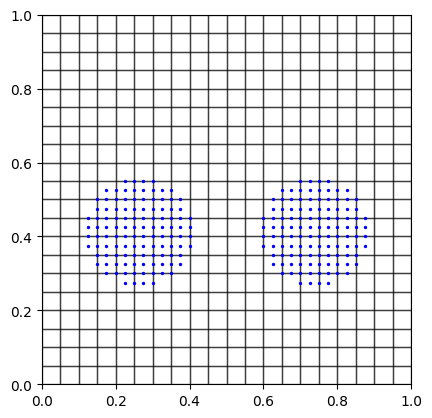

In [10]:
# Plot mesh, particles

def plot_2d_meshes(meshes, particles):
    """
    Plots multiple 2D meshes using node coordinates and face indices.

    Parameters:
    - meshes: A list of tuples, where each tuple contains:
        - node_coords: A NumPy array of shape (n_nodes, 2) containing the (x, y) coordinates of the mesh nodes.
        - faces: A list or array of faces, where each face is represented by a list of node indices (referring to the node_coords).
    - particles: A numpy array for particle coordinates (n_particles, 2) containing the (x, y) positions of the particles.

    Example:
    - meshes = [
        (np.array([[0, 0], [1, 0], [1, 1], [0, 1]]), [[0, 1, 2, 3]]),
        (np.array([[2, 2], [3, 2], [3, 3], [2, 3]]), [[0, 1, 2, 3]])
      ]
    """
    
    # Define a color cycle for different meshes
    colors = itertools.cycle(plt.cm.tab10.colors)  # Using tab10 colormap for up to 10 distinct colors
        
    # Set up the plot
    fig, ax = plt.subplots()
    
    # Iterate over the meshes and plot each one
    for node_coords, faces in meshes:
        # Create a list of polygons using the face indices and node coordinates
        polygons = [node_coords[face] for face in faces]
        
        # Create a PolyCollection from the polygons
        poly_collection = PolyCollection(
            polygons, edgecolors='black', facecolors='none', alpha=0.5)
        
        # Add the PolyCollection to the plot
        ax.add_collection(poly_collection)
        
    ax.scatter(particles[:, 0], particles[:, 1], color='blue', s=2.0)
    
    # Set the limits of the plot to the bounding box of all node coordinates
    all_coords = np.vstack([node_coords for node_coords, _ in meshes])
    ax.set_xlim(np.min(all_coords[:, 0]), np.max(all_coords[:, 0]))
    ax.set_ylim(np.min(all_coords[:, 1]), np.max(all_coords[:, 1]))
    ax.set_aspect('equal')
    
    # Display the plot
    plt.show()
    
meshes = [(nodes, elements)]
plot_2d_meshes(meshes, xp)

## Analysis setting

In [11]:
dtime = 0.001
time = 3
t = 0
output_save_interval = 100
g = 0.5  # Gravity is reduced for taking a larger timestep.

## Computation cycle
We are using explicit USL (update stress last) algoritm. The computation procedure is as follows. The details can be found in the original source ([Nguyen et al., 2023](https://doi.org/10.1007/978-3-031-24070-6)).

The entire computation cycle is as follows.

1. **Initialization**
   1. Set up the Cartesian grid, set time $t = 0$.
   2. Set up particle data: $x^0_p, v^0_p, \sigma^0_p, F^0_p, V^0_p, m_p, \rho_p^0, \rho_p^0$.

2. **while** $t < t_f$ **do**
   1. **Reset grid quantities**: $m^t_I = 0$, $(mv)^t_I = 0$, $f^{ext,t}_I = 0$, $f^{int,t}_I = 0$, $f^t_I = 0$.
   2. **Mapping from particles to nodes (P2G)**
      1. Compute nodal mass 
      
      $$
      m^t_I = \sum_p \phi_I(x^t_p)m_p
      $$

      2. Compute nodal momentum 
      
      $$
      (mv)^t_I = \sum_p \phi_I(x^t_p)(mv)^t_p
      $$

      3. Compute external force 
      
      $$
      f^{ext,t}_I = \sum_p \phi_I(x^t_p)m_pb(x_p)
      $$

      4. Compute internal force 
      
      $$
      f^{int,t}_I = - \sum_p V^0_p \sigma^t_p \nabla \phi_I(x^t_p)
      $$

      5. Compute nodal force 
      
      $$
      f^t_I = f^{ext,t}_I + f^{int,t}_I
      $$

   3. **Update the momenta** 
   
   $$
   (mv)^{t+\Delta t}_I = (mv)^t_I + f^t_I \Delta t
   $$

   4. **Fix Dirichlet nodes $I$**, e.g., $(mv)^t_I = 0$ and $(mv)^{t+\Delta t}_I = 0$.

   5. **Update particles (G2P)**
      1. Get nodal velocities 
      
      $$
      v^t_I = (mv)^t_I / m^t_I \ \text{and} \ v^{t+\Delta t}_I = (mv)^{t+\Delta t}_I / m^t_I
      $$

      2. Update particle velocities

         $$
         v^{t+\Delta t}_p = \alpha \left(v^t_p + \sum_I \phi_I(x^t_p)\left[v^{t+\Delta t}_I - v^t_I \right] \right) + (1 - \alpha) \sum_I \phi_I(x^t_p)v^{t+\Delta t}_I
         $$

      3. Update particle positions 

         $$
         x^{t+\Delta t}_p = x^t_p + \Delta t \sum_I \phi_I(x^t_p)v^{t+\Delta t}_I
         $$

      4. Compute velocity gradient 

         $$
         L^{t+\Delta t}_p = \sum_I \nabla \phi_I(x^t_p)v^{t+\Delta t}_I
         $$

      5. Updated gradient deformation tensor 

         $$
         F^{t+\Delta t}_p = (I + L^{t+\Delta t}_p \Delta t) F^t_p
         $$

      6. Update volume 

         $$
         V^{t+\Delta t}_p = \text{det}(F^{t+\Delta t}_p) V^0_p
         $$

      7. Compute the rate of deformation matrix 

         $$
         D^{t+\Delta t}_p = 0.5(L^{t+\Delta t}_p + (L^{t+\Delta t}_p)^T)
         $$

      8. Compute the strain increment 

         $$
         \Delta \varepsilon_p = \Delta t D^{t+\Delta t}_p
         $$

      9. Update stresses:

         $$
         \sigma^{t+\Delta t}_p = \sigma^t_p + \Delta \sigma \Delta \varepsilon_p \quad \text{or} \quad \sigma^{t+\Delta t}_p = \sigma^t(F^{t+\Delta t}_p)
         $$

   6. **Advance time** $t = t + \Delta t$.
   7. **Error calculation**: if needed (e.g., for convergence tests).

3. **end while**

### Initialization

```python
times = []
kinetic_energy_evolution = []
strain_evergy_evolution = []

nsteps = int(time / dtime)

step = 0
pos = []
vel = []
```


### Start computation cycle (while loop)
#### Reset grid quntities
$m^t_I = 0$, $(mv)^t_I = 0$, $f^{ext,t}_I = 0$, $f^{int,t}_I = 0$, $f^t_I = 0$.

```python
print("Computation cycle started...")
while t < time:
    if step % output_save_interval == 0:
        print(f"Time: {t:.5f}/{time}")

    # Refresh the nodal values
    nodal_masses.fill(0)
    nodal_momentums.fill(0)
    nodal_iforces.fill(0)
    nodal_eforces.fill(0)
    nodal_stresses.fill(0)
```

#### Mapping from particles to nodes (P2G)
```python
    # Iterate over the computational cells (i.e., elements)
    for ele_id in active_elements:
        # node ids of the current element
        node_ids = elements[ele_id]
        # coords of the current element
        node_coords = nodes[node_ids, :]  
        # particle ids inside the current element
        material_points = p_ids_in_eles[ele_id]

        # Iterate over the material points in the current cell
        for p in material_points:
            
            # Convert global coordinate "p=(x, y)" to local coordiate "pt=(xi, eta)".
            pt = np.array(
                [(2 * xp[p, 0] - (node_coords[0, 0] + node_coords[1, 0])) / delta_x,
                 (2 * xp[p, 1] - (node_coords[1, 1] + node_coords[2, 1])) / delta_y])

            # Evaluate shape function and its derivatives with respect to local coords (xi, eta) at (x, y).
            N, dNdxi = utils.lagrange_basis("Q4", pt)
            # Evaluate the Jacobian at current the current local coords (xi, eta).
            jacobian = node_coords.T @ dNdxi
            # Get the inverse of Jacobian
            inv_j = np.linalg.inv(jacobian)
            # Get the derivative of shape function with respect to global coords, i.e., (x, y)
            dNdx = dNdxi @ inv_j
```


---

***Iteration Over Active Elements***

The first step iterates over **active elements**, identified as elements containing particles. For each element:

- **`node_ids`**: Retrieves the indices of the nodes associated with the element.
- **`node_coords`**: Retrieves the spatial coordinates of these nodes:

$$
\text{node coords} = \begin{bmatrix}
x_1 & y_1 \\
x_2 & y_2 \\
x_3 & y_3 \\
x_4 & y_4
\end{bmatrix}
$$

  where $ (x_i, y_i) $ are the global coordinates of the $ i $-th node of the element.

- **`material_points`**: Identifies the particles currently within the element.

---

***Convert Particle Global Coordinates to Local Coordinates***

For each particle $ p $ in the element, its global coordinates $(x_p, y_p)$ are converted into the element's local coordinate system $(\xi, \eta)$.

Formula for Local Coordinates:

$$
\begin{bmatrix}
\xi \\
\eta
\end{bmatrix} = \begin{bmatrix}
\frac{2x_p - (x_1 + x_2)}{\Delta x} \\
\frac{2y_p - (y_1 + y_3)}{\Delta y}
\end{bmatrix}
$$

where:
- $ (x_p, y_p) $: Global coordinates of the particle.
- $ (x_1, y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4) $: Coordinates of the element's corner nodes.
- $ \Delta x, \Delta y $: Width and height of the element.

This transformation normalizes the particle's global coordinates to the element's local coordinate system.

---

***Shape Functions and Their Derivatives***

The **shape functions** $ N $ and their derivatives $ \frac{\partial N}{\partial \xi} $ and $ \frac{\partial N}{\partial \eta} $ are evaluated at the particle's local coordinates $(\xi, \eta)$. For a quadrilateral element (Q4), the shape function matrix $ N(\xi, \eta) $ and its derivative matrix $ \frac{\partial N}{\partial (\xi, \eta)} $ are given as:

Shape Function Matrix:

$$
N(\xi, \eta) = \begin{bmatrix}
\frac{(1-\xi)(1-\eta)}{4} \\
\frac{(1+\xi)(1-\eta)}{4} \\
\frac{(1+\xi)(1+\eta)}{4} \\
\frac{(1-\xi)(1+\eta)}{4}
\end{bmatrix}
$$

Derivative Matrix with Respect to $ (\xi, \eta) $:

$$
\frac{\partial N}{\partial (\xi, \eta)} = \begin{bmatrix}
\frac{\partial N_1}{\partial \xi} & \frac{\partial N_1}{\partial \eta} \\
\frac{\partial N_2}{\partial \xi} & \frac{\partial N_2}{\partial \eta} \\
\frac{\partial N_3}{\partial \xi} & \frac{\partial N_3}{\partial \eta} \\
\frac{\partial N_4}{\partial \xi} & \frac{\partial N_4}{\partial \eta}
\end{bmatrix} = \frac{1}{4}
\begin{bmatrix}
\eta - 1 & \xi - 1 \\
1 - \eta & -1 - \xi \\
\eta + 1 & \xi + 1 \\
-1 - \eta & 1 - \xi
\end{bmatrix}
$$

---

***Jacobian Matrix***

The **Jacobian matrix** $ J $ maps derivatives in the local coordinate space $(\xi, \eta)$ to the global coordinate space $(x, y)$. It is computed as:

$$
J =
\begin{bmatrix}
\frac{\partial x}{\partial \xi} & \frac{\partial y}{\partial \xi} \\
\frac{\partial x}{\partial \eta} & \frac{\partial y}{\partial \eta}
\end{bmatrix} = \text{node coords}^T \cdot \frac{\partial N}{\partial (\xi, \eta)},
$$

where:
- $ \text{node coords} $ is the $ 4 \times 2 $ matrix of node coordinates:

  $$

  \text{node coords} = \begin{bmatrix}
  x_1 & y_1 \\
  x_2 & y_2 \\
  x_3 & y_3 \\
  x_4 & y_4
  \end{bmatrix}
  $$

---

***Inverse Jacobian Matrix***

The inverse of the Jacobian matrix, $ J^{-1} $, is computed to transform the shape function derivatives from local to global coordinates. The element consists of:

$$

\begin{bmatrix}
\frac{\partial \xi}{\partial x} & \frac{\partial \eta}{\partial x} \\
\frac{\partial \xi}{\partial y} & \frac{\partial \eta}{\partial y}
\end{bmatrix}

$$

---

***Global Derivatives of Shape Functions***

Finally, the derivatives of the shape functions with respect to the global coordinates $(x, y)$ are computed as:

$$

\frac{\partial N}{\partial (x, y)} = \frac{\partial N}{\partial (\xi, \eta)} \cdot J^{-1}

$$

In matrix form:

$$
\frac{\partial N}{\partial (x, y)} = \begin{bmatrix}
\frac{\partial N_1}{\partial x} & \frac{\partial N_1}{\partial y} \\
\frac{\partial N_2}{\partial x} & \frac{\partial N_2}{\partial y} \\
\frac{\partial N_3}{\partial x} & \frac{\partial N_3}{\partial y} \\
\frac{\partial N_4}{\partial x} & \frac{\partial N_4}{\partial y}
\end{bmatrix}

$$

---



```python
            # Current stress of material points
            stress = s[p, :]
            
            # Iterate over the nodes of the current element & update nodal values by interpolating material point values
            for i, node_id in enumerate(node_ids):
                dNIdx = dNdx[i, 0]
                dNIdy = dNdx[i, 1]
                nodal_masses[node_id] += N[i] * Mp[p]
                nodal_momentums[node_id, :] += N[i] * Mp[p] * vp[p, :]
                nodal_iforces[node_id, 0] -= Vp[p] * (stress[0] * dNIdx + stress[2] * dNIdy)
                nodal_iforces[node_id, 1] -= Vp[p] * (stress[2] * dNIdx + stress[1] * dNIdy)
                nodal_eforces[node_id, 1] -= N[i] * Mp[p] * g

    nforce = nodal_iforces + nodal_eforces
```


After determining the derivatives of the shape functions with respect to global coordinates, the material point quantities (such as mass, momentum, and forces) are mapped to the corresponding nodal values using the shape functions $ N_i (\xi, \eta) $ and their derivatives.  

For each material point $ p $, the following computations are performed:

***Nodal Mass Update***  

   The mass of a node $ I $ is updated by summing the contributions from the material points:  

   $$ m_I^t \mathrel{+}= N_i \cdot m_p $$

   where:  

   - $ N_i $ is the shape function value at the location of the material point, corresponding to node $ i $.  
   - $ m_p $ is the mass of the material point.  

***Nodal Momentum Update***  

   The nodal momentum is updated by adding the momentum contribution of the material point:  

   $$ (mv)_I^t \mathrel{+}= N_i \cdot m_p \cdot \mathbf{v}_p $$

   where:  

   - $ \mathbf{v}_p $ is the velocity of the material point.  

***Internal Force Update***

   The internal forces are computed using the Cauchy stress tensor $ \sigma $ and the derivatives of the shape functions with respect to global coordinates: 

   $$ f_I^{int,t,x} \mathrel{-}= V_p \cdot \left( \sigma_{xx} \cdot \frac{\partial N_i}{\partial x} + \sigma_{xy} \cdot \frac{\partial N_i}{\partial y} \right) $$
   $$ f_I^{int,t,y} \mathrel{-}= V_p \cdot \left( \sigma_{xy} \cdot \frac{\partial N_i}{\partial x} + \sigma_{yy} \cdot \frac{\partial N_i}{\partial y} \right) $$
   
   where:  

   - $ V_p $ is the volume of the material point.  
   - $ \sigma_{xx}, \sigma_{yy}, \sigma_{xy} $ are components of the stress tensor at the material point.  

***External Force Update***

   The external forces are computed using body forces such as gravity $ \mathbf{g} $:  

   $$ f_I^{ext,t,y} \mathrel{-}= N_i \cdot m_p \cdot g $$

   where $ g $ is the gravitational acceleration.

***Nodal Force Calculation***

   The total force at each node is the sum of internal and external forces: 

   $$ f_I^t = f_I^{int,t} + f_I^{ext,t} $$


***Matrix Notation for Forces***

In matrix form, the internal force at a node $ I $ can be expressed as:  

$$ \mathbf{f}_I^{int,t} = -\mathbf{B}_I^T \cdot \boldsymbol{\sigma} \cdot V_p $$  

where:  

- $ \mathbf{B}_I $ is the strain-displacement matrix derived from $ \frac{\partial N}{\partial x} $ and $ \frac{\partial N}{\partial y} $.  
- $ \boldsymbol{\sigma} $ is the stress tensor.  

For the external force:  

$$ \mathbf{f}_I^{ext,t} = \int_\Omega N_i \cdot \mathbf{b} \, d\Omega $$  

where $ \mathbf{b} $ is the body force (e.g., gravity).  

By summing these contributions, the total nodal force $ \mathbf{f}_I^t $ is obtained.  


#### Update the momenta and impose boundary condition

```python
    # Impose boundary condition
    nodal_momentums[left_nodes, 0] = 0
    nodal_momentums[right_nodes, 0] = 0
    nodal_momentums[bottom_nodes, 1] = 0
    nodal_momentums[upper_nodes, 1] = 0
    nforce[left_nodes, 0] = 0
    nforce[right_nodes, 0] = 0
    nforce[bottom_nodes, 1] = 0
    nforce[upper_nodes, 1] = 0
    
    # Update nomal momentum
    nodal_momentums += nforce * dtime
```

#### Update particles (G2P)
```python
    # Iterate over the computational cells (i.e., elements)
    for ele_id in active_elements:
        # node ids of the current element
        node_ids = elements[ele_id]
        # coords of the current element
        node_coords = nodes[node_ids, :]  
        # particle ids inside the current element
        material_points = p_ids_in_eles[ele_id]

        # Iterate over the material points in the current cell
        for p in material_points:
            # Convert global coordinate "p=(x, y)" to local coordiate "pt=(xi, eta)".
            pt = np.array(
                [(2 * xp[p, 0] - (node_coords[0, 0] + node_coords[1, 0])) / delta_x,
                 (2 * xp[p, 1] - (node_coords[1, 1] + node_coords[2, 1])) / delta_y])

            N, dNdxi = utils.lagrange_basis("Q4", pt)  # shape function and its derivatives
            jacobian = node_coords.T @ dNdxi  # jacobian
            inv_j = np.linalg.inv(jacobian)
            dNdx = dNdxi @ inv_j
            Lp = np.zeros((2, 2))
            
            for i, node_id in enumerate(node_ids):
                vI = np.zeros(2)
                vp[p, :] += dtime * N[i] * nforce[node_id, :] / nodal_masses[node_id]
                xp[p, :] += dtime * N[i] * nodal_momentums[node_id, :] / nodal_masses[node_id]
                vI = nodal_momentums[node_id, :] / nodal_masses[node_id]  # nodal velocity
                Lp += vI.reshape(2, 1) @ dNdx[i, :].reshape(1, 2)  # particle velocity gradient

            F = Fp[p, :].reshape(2, 2) @ (np.eye(2) + Lp * dtime)  # deformation gradient
            Fp[p, :] = F.flatten()
            Vp[p] = np.linalg.det(F) * Vp0[p]  # update particle volume
            dEps = dtime * 0.5 * (Lp + Lp.T)  # strain increment
            dsigma = C @ np.array([dEps[0, 0], dEps[1, 1], 2 * dEps[0, 1]])  # stress increment
            s[p, :] += dsigma  # update stress
            eps[p, :] += [dEps[0, 0], dEps[1, 1], 2 * dEps[0, 1]]  # update strain

            kinetic_energy += 0.5 * (vp[p, 0] ** 2 + vp[p, 1] ** 2) * Mp[p]
            strain_energy += 0.5 * Vp[p] * s[p, :] @ eps[p, :]

            for i, node_id in enumerate(node_ids):
                nodal_stresses[:, node_id] += N[i] * s[p, :]

    pos.append(xp.copy())
    vel.append(vp.copy())
    
    # Update particle-element mapping (elements to which particles belong)
    ele_ids_of_particles, p_ids_in_eles = utils.particle_element_mapping(
        xp, delta_x, delta_y, n_ele_x, n_elements)
    active_elements = np.unique(ele_ids_of_particles)
    active_nodes = np.unique(elements[active_elements, :])

```


This part of the code computes particle updates (velocity, position, stress, strain, deformation gradient, etc.) based on nodal values (forces and momenta) and redistributes updated stresses back to the nodes. Here's the step-by-step explanation with relevant mathematical formulations:

---

***Iterate Over Elements and Particles***

For each element $ e $:
- Retrieve:
  - **Node indices**: $ \text{node ids} = \{n_1, n_2, n_3, n_4\} $, representing the indices of the element's nodes.
  - **Node coordinates**: $ \text{node coords} $, the global positions of the nodes.
  - **Particle IDs**: $ \text{material points} $, the IDs of the particles within the current element.

For each particle $ p $ within the element, we compute its updates as follows:

---

***Convert Global to Local Coordinates***

The particle's global position $(x_p, y_p)$ is transformed into the local coordinate system $(\xi, \eta)$ using:

$$
\begin{bmatrix}
\xi \\
\eta
\end{bmatrix} = \begin{bmatrix}
\frac{2x_p - (x_1 + x_2)}{\Delta x} \\
\frac{2y_p - (y_1 + y_3)}{\Delta y}
\end{bmatrix},
$$

where $ \Delta x $ and $ \Delta y $ are the element's dimensions.

---

***Compute Shape Functions and Their Gradients***

- **Shape functions $ N(\xi, \eta) $**:
  The values of the shape functions at $(\xi, \eta)$ are interpolated to determine how particle quantities are distributed to nodes.

- **Gradients of Shape Functions**:
  The derivatives of the shape functions with respect to global coordinates $(x, y)$ are computed as:

  $$
  \frac{\partial N}{\partial (x, y)} = \frac{\partial N}{\partial (\xi, \eta)} \cdot J^{-1},
  $$

  where $ J $ is the Jacobian matrix.

---

***Update Particle Velocity and Position***

**Particle Velocity Update**:
The velocity of the particle $ \mathbf{v}_p $ is updated using the nodal forces $ \mathbf{f}_I $:

$$
\mathbf{v}_p^{t+\Delta t} = \mathbf{v}_p^{t} + \Delta t \sum_{i} N_i(x_p) \frac{\mathbf{f}_i}{m_i}
$$

where $ N_i(x_p) $ is the shape function value, $ \mathbf{f}_i = \text{nforce[node id]} $, and $ m_i = \text{nodal masses[node id]} $.

**Particle Position Update**:
The particle position $ \mathbf{x}_p $ is updated using the nodal momentum $ \mathbf{p}_I $:

$$
\mathbf{x}_p^{t+\Delta t} = \mathbf{x}_p^{t} + \Delta t \sum_{i} N_i(x_p) \frac{\mathbf{p}_i}{m_i}
$$

where $ \mathbf{p}_i = \text{nodal momentums[node id]} $.

---

***Compute Particle Velocity Gradient***

The velocity gradient at the particle is computed using:

$$
\mathbf{L}_p = \sum_i \mathbf{v}_I \frac{\partial N_i}{\partial (x, y)}
$$

where:
- $ \mathbf{v}_I = \frac{\mathbf{p}_i}{m_i} $: Velocity of node $ i $.
- $ \frac{\partial N_i}{\partial (x, y)} $: Gradient of the shape function.

---

***Update Deformation Gradient***

The deformation gradient $ \mathbf{F}_p $ is updated using the velocity gradient:

$$
\mathbf{F}_p^{t+\Delta t} = \mathbf{F}_p^t \cdot \left( \mathbf{I} + \mathbf{L}_p \cdot \Delta t \right)
$$

where $ \mathbf{I} $ is the identity matrix.

---

***Update Particle Volume***

The particle volume is updated using the determinant of the deformation gradient:

$$
V_p^{t+\Delta t} = \text{det}(\mathbf{F}_p^{t+\Delta t}) \cdot V_p^0
$$

where $ V_p^0 $ is the initial volume of the particle.

---

***Compute Strain Increment***

The strain increment $ \Delta \boldsymbol{\varepsilon}_p $ is computed as:

$$
\Delta \boldsymbol{\varepsilon}_p = \Delta t \cdot \frac{1}{2} \left( \mathbf{L}_p + \mathbf{L}_p^T \right) = \Delta t \cdot \boldsymbol{D}
$$

where $ \mathbf{L}_p $ is the velocity gradient.

---

***Update Stress***

The stress increment is computed using the material's constitutive model:

$$
\Delta \boldsymbol{\sigma}_p = f (\boldsymbol{\sigma}_p, \Delta \boldsymbol{\varepsilon}_p, \boldsymbol{\theta})
$$

Where, $\boldsymbol{\theta}$ is the model parameters.

The updated stress is:

$$
\boldsymbol{\sigma}_p^{t+\Delta t} = \boldsymbol{\sigma}_p^t + \Delta \boldsymbol{\sigma}_p
$$

---

***Map Stresses to Nodes***

Finally, stresses are interpolated back to the nodes:

$$
\mathbf{s}_I = \mathbf{s}_I + N_i(x_p) \cdot \boldsymbol{\sigma}_p
$$

where $ N_i(x_p) $ is the shape function value at the particle position.



### Advance time

```python
    t += dtime
    step += 1
```

## Complete code

In [13]:
times = []
kinetic_energy_evolution = []
strain_evergy_evolution = []

nsteps = int(time / dtime)

step = 0
pos = []
vel = []

print("Computation cycle started...")
while t < time:
    if step % output_save_interval == 0:
        print(f"Time: {t:.5f}/{time}")

    # Refresh the nodal values
    nodal_masses.fill(0)
    nodal_momentums.fill(0)
    nodal_iforces.fill(0)
    nodal_eforces.fill(0)
    nodal_stresses.fill(0)
    
    # Iterate over the computational cells (i.e., elements)
    for ele_id in active_elements:
        # node ids of the current element
        node_ids = elements[ele_id]
        # coords of the current element
        node_coords = nodes[node_ids, :]  
        # particle ids inside the current element
        material_points = p_ids_in_eles[ele_id]

        # Iterate over the material points in the current cell
        for p in material_points:
            
            # Convert global coordinate "p=(x, y)" to local coordiate "pt=(xi, eta)".
            pt = np.array(
                [(2 * xp[p, 0] - (node_coords[0, 0] + node_coords[1, 0])) / delta_x,
                 (2 * xp[p, 1] - (node_coords[1, 1] + node_coords[2, 1])) / delta_y])

            # Evaluate shape function and its derivatives with respect to local coords (xi, eta) at (x, y).
            N, dNdxi = lagrange_basis("Q4", pt)
            # Evaluate the Jacobian at current the current local coords (xi, eta).
            jacobian = node_coords.T @ dNdxi
            # Get the inverse of Jacobian
            inv_j = np.linalg.inv(jacobian)
            # Get the derivative of shape function with respect to global coords, i.e., (x, y)
            dNdx = dNdxi @ inv_j

            # Current stress of material points
            stress = s[p, :]
            
            # Iterate over the nodes of the current element & update nodal values by interpolating material point values
            for i, node_id in enumerate(node_ids):
                dNIdx = dNdx[i, 0]
                dNIdy = dNdx[i, 1]
                nodal_masses[node_id] += N[i] * Mp[p]
                nodal_momentums[node_id, :] += N[i] * Mp[p] * vp[p, :]
                nodal_iforces[node_id, 0] -= Vp[p] * (stress[0] * dNIdx + stress[2] * dNIdy)
                nodal_iforces[node_id, 1] -= Vp[p] * (stress[2] * dNIdx + stress[1] * dNIdy)
                nodal_eforces[node_id, 1] -= N[i] * Mp[p] * g

    nforce = nodal_iforces + nodal_eforces
    
    # Impose boundary condition
    nodal_momentums[left_nodes, 0] = 0
    nodal_momentums[right_nodes, 0] = 0
    nodal_momentums[bottom_nodes, 1] = 0
    nodal_momentums[upper_nodes, 1] = 0
    nforce[left_nodes, 0] = 0
    nforce[right_nodes, 0] = 0
    nforce[bottom_nodes, 1] = 0
    nforce[upper_nodes, 1] = 0
    
    # Update nomal momentum
    nodal_momentums += nforce * dtime    
    
    kinetic_energy = 0
    strain_energy = 0
    
    # Iterate over the computational cells (i.e., elements)
    for ele_id in active_elements:
        # node ids of the current element
        node_ids = elements[ele_id]
        # coords of the current element
        node_coords = nodes[node_ids, :]  
        # particle ids inside the current element
        material_points = p_ids_in_eles[ele_id]

        # Iterate over the material points in the current cell
        for p in material_points:
            # Convert global coordinate "p=(x, y)" to local coordiate "pt=(xi, eta)".
            pt = np.array(
                [(2 * xp[p, 0] - (node_coords[0, 0] + node_coords[1, 0])) / delta_x,
                 (2 * xp[p, 1] - (node_coords[1, 1] + node_coords[2, 1])) / delta_y])

            N, dNdxi = lagrange_basis("Q4", pt)  # shape function and its derivatives
            jacobian = node_coords.T @ dNdxi  # jacobian
            inv_j = np.linalg.inv(jacobian)
            dNdx = dNdxi @ inv_j
            Lp = np.zeros((2, 2))
            
            for i, node_id in enumerate(node_ids):
                vI = np.zeros(2)
                vp[p, :] += dtime * N[i] * nforce[node_id, :] / nodal_masses[node_id]
                xp[p, :] += dtime * N[i] * nodal_momentums[node_id, :] / nodal_masses[node_id]
                vI = nodal_momentums[node_id, :] / nodal_masses[node_id]  # nodal velocity
                Lp += vI.reshape(2, 1) @ dNdx[i, :].reshape(1, 2)  # particle velocity gradient

            F = Fp[p, :].reshape(2, 2) @ (np.eye(2) + Lp * dtime)  # deformation gradient
            Fp[p, :] = F.flatten()
            Vp[p] = np.linalg.det(F) * Vp0[p]  # update particle volume
            dEps = dtime * 0.5 * (Lp + Lp.T)  # strain increment
            dsigma = C @ np.array([dEps[0, 0], dEps[1, 1], 2 * dEps[0, 1]])  # stress increment
            s[p, :] += dsigma  # update stress
            eps[p, :] += [dEps[0, 0], dEps[1, 1], 2 * dEps[0, 1]]  # update strain

            kinetic_energy += 0.5 * (vp[p, 0] ** 2 + vp[p, 1] ** 2) * Mp[p]
            strain_energy += 0.5 * Vp[p] * s[p, :] @ eps[p, :]

            for i, node_id in enumerate(node_ids):
                nodal_stresses[:, node_id] += N[i] * s[p, :]

    pos.append(xp.copy())
    vel.append(vp.copy())
    
    # Update particle-element mapping (elements to which particles belong)
    ele_ids_of_particles, p_ids_in_eles = particle_element_mapping(
        xp, delta_x, delta_y, n_ele_x, n_elements)
    active_elements = np.unique(ele_ids_of_particles)
    active_nodes = np.unique(elements[active_elements, :])

    times.append(t)
    kinetic_energy_evolution.append(kinetic_energy)
    strain_evergy_evolution.append(strain_energy)

    # if step % output_save_interval == 0:
    #     result = {"positions": xp, "stress": s}
    #     save_dir = f"./results_vtk/"
    #     visualizer.save_vtk(step, result, save_dir)
        
    t += dtime
    step += 1
    

Computation cycle started...
Time: 0.00000/3
Time: 0.10000/3
Time: 0.20000/3
Time: 0.30000/3
Time: 0.40000/3
Time: 0.50000/3
Time: 0.60000/3
Time: 0.70000/3
Time: 0.80000/3
Time: 0.90000/3
Time: 1.00000/3
Time: 1.10000/3
Time: 1.20000/3
Time: 1.30000/3
Time: 1.40000/3
Time: 1.50000/3
Time: 1.60000/3
Time: 1.70000/3
Time: 1.80000/3
Time: 1.90000/3
Time: 2.00000/3
Time: 2.10000/3
Time: 2.20000/3
Time: 2.30000/3
Time: 2.40000/3
Time: 2.50000/3
Time: 2.60000/3
Time: 2.70000/3
Time: 2.80000/3
Time: 2.90000/3
Time: 3.00000/3


## Visualize the result

### Trajectory

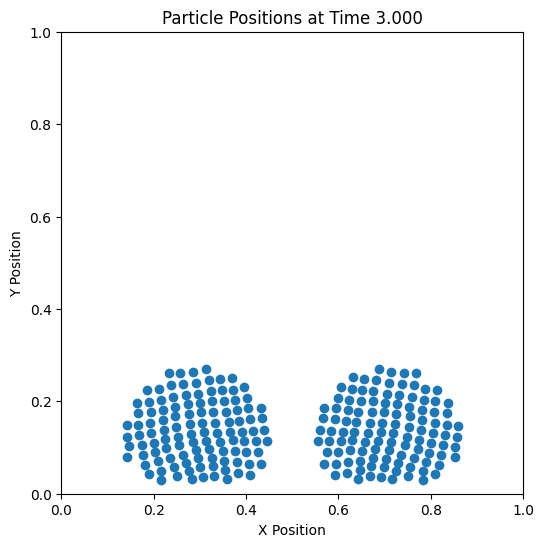

In [14]:
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Particle Positions Over Time')

# Initialize a scatter plot
scat = ax.scatter([], [])

# Update function for animation
def update(frame):
    scat.set_offsets(pos[frame])
    ax.set_title(f'Particle Positions at Time {times[frame]:.3f}')
    ax.set_aspect('equal')
    return scat,

# Create the animation
ani = FuncAnimation(
    fig, update, frames=range(0, len(times), output_save_interval), interval=100, blit=True)

# Display the animation in the notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

### Energy evolution

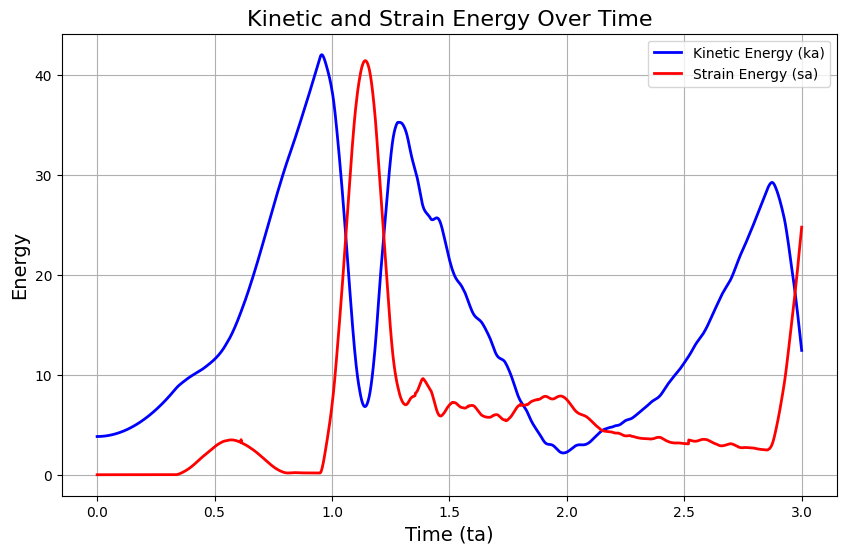

In [15]:
# Plot kinetic and strain energy
plt.figure(figsize=(10, 6))
plt.plot(times, kinetic_energy_evolution, label='Kinetic Energy (ka)', color='b', linewidth=2)
plt.plot(times, strain_evergy_evolution, label='Strain Energy (sa)', color='r', linewidth=2)
plt.xlabel('Time (ta)', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Kinetic and Strain Energy Over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()